## To do first

1. download the sequencing libraries from the NCBI SRA (SRR17032111)
2. copy the following directories:
    - uni_amplicon_sequences
    - amplicon_sequences
3. copy the sample datasheet
4. make sure you have the correct set of packages and programs (see repo homepage for details). In particular, the path to the Trimmomatic software will need to be ajusted depending on the install location spcific to your environment.
5. make sure you adjust the number of threads depending on your available computationnal resources

## Imports

In [1]:
import os
import subprocess

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter
#

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
pandas 1.2.1
numpy 1.19.2
matplotlib 3.3.2
scipy 1.5.2
seaborn 0.11.1


## Basic Function and Data Imports

In [2]:
def reverse_complement(dna):
    """ function that reverse complements DNA
    dna: input dna sequence
    """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in dna[::-1]])

def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict


universal_seqs_fasta = "./uni_amplicon_sequences/universal_amplicon.fa"
universal_seqs = get_dict_of_seq(universal_seqs_fasta)
print(universal_seqs)
# import the universal amplicon components of Row-column indexing (see Yachie et al 2016, Molecular Systems Biology)

indexes_fasta = "./uni_amplicon_sequences/indexes.fa"
indexes = get_dict_of_seq(indexes_fasta)
print(indexes)
# import the DNA barcodes used in Row-column indexing (see Yachie et al 2016, Molecular Systems Biology)

degen_seq = 'AAAAA'
# to increase sequence diversity on the flowcell, the oligonucleotides that add the Illumina indexes to the amplicons
# incorporate a stretch of 5 degenerate bases (N) just after the sequencing primer binding sites. Since Bowtie cannot
# process Ns, we replace them with As in the predicted amplicon sequences used to generate the alignment indexes

{'Index_five_prime': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTNNNNN', 'Index_three_prime': 'NNNNNAGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG', 'plate_fivep_sticky': 'TAACTTACGGAGTCGCTCTACG', 'RC_fivep_sticky': 'CCATACGAGCACATTACGGG', 'plate_threep_sticky': 'CAGGACCTAAAGAATCCCATCC', 'RC_threep_sticky': 'CCTCAGTCGCTCAGTCAAG', 'five_prime_adapter': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT', 'three_prime_adapter': 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG'}
{'1': 'CAAGTGTTC', '2': 'AGGACATTC', '3': 'CACTAATGG', '4': 'AGCCTGATG', '5': 'TTACGCTAA', '6': 'ACTCTCCGT', '7': 'GTCGATGCA', '8': 'ACGGGAATT', '9': 'CGCGCCCAG', '10': 'ACTAGTTTG', '11': 'AGTATTACA', '12': 'AGGTTGGGT', '13': 'GTGAACCGA', '14': 'GCACAAAAC', '15': 'CTGTCTTCG', '16': 'GACGCGACT', '17': 'CAGCCCATA', '18': 'AGATATCTG'}


### Check sequencing quality with Fastqc and select for seqs w/ correct length

In [3]:
experiment_name = 'FCY1_screen'
path_to_R1_file = './data/PhilD-samples_S1_L001_R1_001.fastq.gz'
path_to_R2_file = './data/PhilD-samples_S1_L001_R2_001.fastq.gz'
# Path to compressed files. Change according to filename or location.

In [4]:
subprocess.check_output('fastqc '+path_to_R1_file, shell=True)
# Run Fastqc on the R1 (forward) compressed sequencing file
subprocess.check_output('fastqc '+path_to_R2_file, shell=True)
# Run Fastqc on the R2 (forward) compressed sequencing file

b'Analysis complete for PhilD-samples_S1_L001_R2_001.fastq.gz\n'

In [5]:
if 'temp' not in os.listdir():
    os.mkdir('./temp')

In [6]:
trim_call = 'java -jar ../../../../Downloads/Trimmomatic-0.39/trimmomatic-0.39.jar PE -threads 6 -trimlog log.txt '
trim_call += path_to_R1_file+' '+path_to_R2_file+' '+'-baseout ./temp/minlen299.fastq MINLEN:299 CROP:270'
trim_call
# generate a Trimmomatic call that performs 2 actions::
#    MINLEN:299    drops all sequences shorter than 299
#    CROP:270      crops sequences from the 3-prime end to a uniform length of 270
# only reads for which both the forward and the reverse survice this step are considered for the rest of the analysis

'java -jar ../../../../Downloads/Trimmomatic-0.39/trimmomatic-0.39.jar PE -threads 6 -trimlog log.txt ./data/PhilD-samples_S1_L001_R1_001.fastq.gz ./data/PhilD-samples_S1_L001_R2_001.fastq.gz -baseout ./temp/minlen299.fastq MINLEN:299 CROP:270'

In [7]:
subprocess.check_output(trim_call, shell=True)
# run the call

b''

In [10]:
subprocess.check_output('fastqc '+'./temp/minlen299_1P.fastq', shell=True)
subprocess.check_output('fastqc '+'./temp/minlen299_2P.fastq', shell=True)
# perfom some QC on the trimmed sequences

b'Analysis complete for minlen299_2P.fastq\n'

In [8]:
if 'amplicon_sequences' not in os.listdir():
    os.mkdir('./amplicon_sequences')
if 'bowtie_indexes' not in os.listdir():
    os.mkdir('./bowtie_indexes')   
# checks for the presence of two directories, and if not creates them.

## Generate bowtie indexes to align the plate barcodes

In [9]:
plate_index_pair_list = [(1,3), (2,3), (3,3), (2,2)]

plate_pcr_amplicon_for = './amplicon_sequences/plate_pcr_for.fa'
plate_pcr_amplicon_rev = './amplicon_sequences/plate_pcr_rev.fa'
# path to the fasta file that will contain the amplicon sequences

for_plate_indexes = [1,2,3]
print(for_plate_indexes)

rev_plate_indexes = [1,2,3]
print(rev_plate_indexes)
# list of indexes (from ./uni_amplicon_sequences/indexes.fa) allowed as plate barcodes



with open(plate_pcr_amplicon_for, 'w') as fasta_out:
    # opens the forward plate amplicon file
    
    for index in for_plate_indexes:
        # for each allowed forward index:

        index_seq = indexes[str(index)]
        # get the index sequence
        
        header = '>'+str(index)+'\n'
        # generate the fasta header (name of the sequence is just the index number)
        # write the header
        fasta_out.write(header)
        
        
        amplicon_frag = degen_seq+index_seq+universal_seqs['plate_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        # add amplicon parts to generate the reference sequence for the index
        # write the sequence        
        
for_plate_index = './bowtie_indexes/'+experiment_name+'_for_plate'
# name the bowtie index
for_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_for+' '+for_plate_index
# generate the bowtie-biuld call to generate the index files
for_plate_indexing_log = subprocess.check_output(for_plate_bowtie_index_call, shell=True)
# generate the bowtie forward plate indexes
        
with open(plate_pcr_amplicon_rev, 'w') as fasta_out:
    # opens the forward plate amplicon file

    
    for index in rev_plate_indexes:
        # for each allowed reverse index:

        index_seq = indexes[str(index)]
        # get the index sequence
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        # generate the fasta header (name of the sequence is just the index number)
        # write the header
        
        amplicon_frag = degen_seq + index_seq+ reverse_complement(universal_seqs['plate_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)
        # add amplicon parts to generate the reference sequence for the index
        # write the sequence      
    
rev_plate_index = './bowtie_indexes/'+experiment_name+'_rev_plate'
# name the bowtie index
rev_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_rev+' '+rev_plate_index
# generate the bowtie-biuld call to generate the index files
rev_plate_indexing_log = subprocess.check_output(rev_plate_bowtie_index_call, shell=True)
# generate the bowtie forward plate indexes

[1, 2, 3]
[1, 2, 3]


## align forward plate barcode

In [10]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 250 --trim5 5 --norc --chunkmbs 256 '
# align the forward plate barcode in the R1 files (parameters adjusted for CROP:270)
# the options used are:
#    -t                report time used at each step
#    -v 3              allow a maximum of 3 mismatches
#    -p 6              use 6 threads
#    -k 1              report only one alignment for each sequence
#    --trim3 250       trim 250 nucleotides from the end of the sequence
#    --trim5 5         trim the 5 first bases of the sequence (corresponds to the degenerate positions)
#    -norc             do not try to reverse complement sequence align on the index
#    --chunkmbs 256    increases memory per thread to find the beast alignments

test_align_call += for_plate_index+' '
# specify the index on which to align
test_align_call += './temp/minlen299_1P.fastq '
# specify the input path
test_align_call += './temp/plate_for_align.txt'
# specify the output path

print(test_align_call)
# inspect the call

subprocess.check_output(test_align_call, shell = True)
# run the forward plate barcode alignment

bowtie -t -v 3 -p 6 -k 1 --trim3 250 --trim5 5 --norc --chunkmbs 256 ./bowtie_indexes/FCY1_screen_for_plate ./temp/minlen299_1P.fastq ./temp/plate_for_align.txt


b''

In [11]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 250 --trim5 5 --norc --chunkmbs 256 '
# align the reverse plate barcode in the R2 files (parameters adjusted for CROP:270)
# the options used are:
#    -t                report time used at each step
#    -v 3              allow a maximum of 3 mismatches
#    -p 6              use 6 threads
#    -k 1              report only one alignment for each sequence
#    --trim3 250       trim 250 nucleotides from the end of the sequence
#    --trim5 5         trim the 5 first bases of the sequence (corresponds to the degenerate positions)
#    -norc             do not try to reverse complement sequence align on the index
#    --chunkmbs 256    increases memory per thread to find the beast alignments

test_align_call += rev_plate_index+' '
# specify the index on which to align
test_align_call += './temp/minlen299_2P.fastq '
# specify the input path
test_align_call += './temp/plate_rev_align.txt'
# specify the output path

print (test_align_call)
# inspect the call

subprocess.check_output(test_align_call, shell = True)
# run the forward plate barcode alignment

bowtie -t -v 3 -p 6 -k 1 --trim3 250 --trim5 5 --norc --chunkmbs 256 ./bowtie_indexes/FCY1_screen_rev_plate ./temp/minlen299_2P.fastq ./temp/plate_rev_align.txt


b''

In [12]:
plate_align_for_output = './temp/plate_for_align.txt'
plate_align_rev_output = './temp/plate_rev_align.txt'
# path to the plate barcode alignments


plate_index_found_for = {}
plate_index_found_rev = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(plate_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        plate_index_found_for[read_name] = line[2]
        # add read P1 index to dict

# log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(plate_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        plate_index_found_rev[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


plate_both = list(set(plate_index_found_for.keys()) & set(plate_index_found_rev.keys()))
# log_entry['both_index'] = len(both_indexes)
# Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# that number for the read pack in the log


print(len(plate_both))
# check the number of reads that have valid alignments for both plate barcodes



17053967


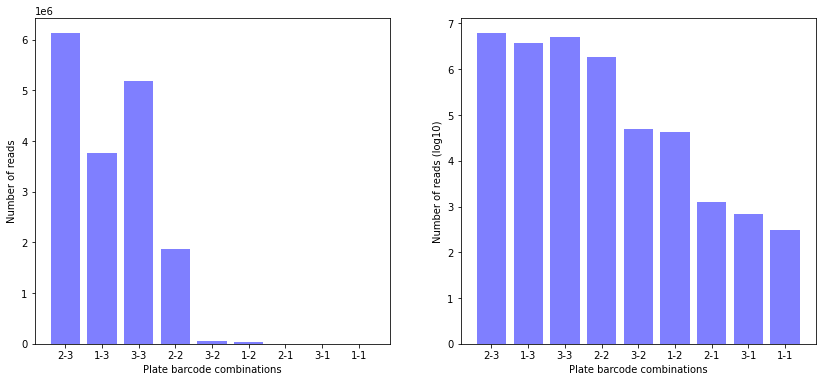

In [13]:
def plot_reads_per_plate(shared_index_list, index_for_dict, index_rev_dict):
    # plots the number of reads for each combination of plate barcodes
    
    plate_read_counter = Counter()
    # counter object that will hold counts for each pair
    
    for read in shared_index_list:
        # for each read with 2 valid alignments
        
        for_index = index_for_dict[read]
        rev_index = index_rev_dict[read]
        # extract indexes from dicts
        
        plate = for_index+'-'+rev_index        
        plate_read_counter[plate] +=1
        # generate index pair, then increment counter
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    # first plot, linear scale
    
    plt.bar(range(len(plate_read_counter)), list(plate_read_counter.values()), align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads')
    # plot number of reads for each barcode pair
    
    plt.subplot(122)
    # second plot, log10 scale
    
    plt.bar(range(len(plate_read_counter)), [np.log10(x) for x in plate_read_counter.values()], align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads (log10)')
    # plot log10 number of reads for each barcode pair

    
plot_reads_per_plate(plate_both, plate_index_found_for, plate_index_found_rev)

## Align Row-Column (RC) barcodes

In [14]:
RC_pcr_amplicon_for = './amplicon_sequences/RC_pcr_for.fa'
RC_pcr_amplicon_rev = './amplicon_sequences/RC_pcr_rev.fa'
# path to the fasta file that will contain the amplicon sequences


RC_for_indexes = range(1,16)
print(RC_for_indexes)

RC_rev_indexes = range(1,16)
print(RC_rev_indexes)

# list of indexes (from ./uni_amplicon_sequences/indexes.fa) allowed as RC barcodes


with open(RC_pcr_amplicon_for, 'w') as fasta_out:
    # opens the forward RC amplicon file
    
    for index in RC_for_indexes:
        # for each allowed forward index:

        index_seq = indexes[str(index)]
        # get the index sequence
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        # generate the fasta header (name of the sequence is just the index number)
        # write the header
        
        amplicon_frag = universal_seqs['plate_fivep_sticky']+index_seq+universal_seqs['RC_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        # add amplicon parts to generate the reference sequence for the index
        # write the sequence        
        
        
for_RC_index = './bowtie_indexes/'+experiment_name+'_for_RC'
# name the bowtie index
for_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_for+' '+for_RC_index
# generate the bowtie-biuld call to generate the index files
for_RC_indexing_log = subprocess.check_output(for_RC_bowtie_index_call, shell=True)
# generate the bowtie forward RC indexes
        
        
with open(RC_pcr_amplicon_rev, 'w') as fasta_out:
    # opens the reverse RC amplicon file
    
    for index in RC_rev_indexes:
        # for each allowed reverse index:

        index_seq = indexes[str(index)]
        # get the index sequence
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        # generate the fasta header (name of the sequence is just the index number)
        # write the header
        
        amplicon_frag = reverse_complement(universal_seqs['plate_threep_sticky']) + index_seq
        amplicon_frag += reverse_complement(universal_seqs['RC_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)    
        # add amplicon parts to generate the reference sequence for the index
        # write the sequence 
    
rev_RC_index = './bowtie_indexes/'+experiment_name+'_rev_RC'
# name the bowtie index
rev_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_rev+' '+rev_RC_index
# generate the bowtie-biuld call to generate the index files
rev_RC_indexing_log = subprocess.check_output(rev_RC_bowtie_index_call, shell=True)
# generate the bowtie forward reverse indexes   

range(1, 16)
range(1, 16)


In [15]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 215 --trim5 28 --norc --chunkmbs 256 '
# align the forward RC barcode in the R1 files (parameters adjusted for CROP:270)
# the options used are:
#    -t                report time used at each step
#    -v 3              allow a maximum of 3 mismatches
#    -p 6              use 6 threads
#    -k 1              report only one alignment for each sequence
#    --trim3 215       trim 250 nucleotides from the end of the sequence
#    --trim5 28         trim the 5 first bases of the sequence (corresponds to the degenerate positions)
#    -norc             do not try to reverse complement sequence align on the index
#    --chunkmbs 256    increases memory per thread to find the beast alignments

test_align_call += for_RC_index+' '
# specify the index on which to align
test_align_call += './temp/minlen299_1P.fastq '
# specify the input path
test_align_call += './temp/RC_for_align.txt'
# specify the output path

subprocess.check_output(test_align_call, shell = True)
# run the forward RC barcode alignment

b''

In [16]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 217 --trim5 26 --norc --chunkmbs 256 '
# align the reverse RC barcode in the R1 files (parameters adjusted for CROP:270)
# the options used are:
#    -t                report time used at each step
#    -v 3              allow a maximum of 3 mismatches
#    -p 6              use 6 threads
#    -k 1              report only one alignment for each sequence
#    --trim3 217       trim 250 nucleotides from the end of the sequence
#    --trim5 26        trim the 5 first bases of the sequence (corresponds to the degenerate positions)
#    -norc             do not try to reverse complement sequence align on the index
#    --chunkmbs 256    increases memory per thread to find the beast alignments

test_align_call += rev_RC_index+' '
# specify the index on which to align
test_align_call += './temp/minlen299_2P.fastq '
# specify the input path
test_align_call += './temp/RC_rev_align.txt'
# specify the output path

subprocess.check_output(test_align_call, shell = True)
# run the reverse RC barcode alignment

b''

In [17]:
RC_align_for_output = './temp/RC_for_align.txt'
RC_align_rev_output = './temp/RC_rev_align.txt'
# path to the RC barcode alignments

index_found_for_RC = {}
index_found_rev_RC = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(RC_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        index_found_for_RC[read_name] = line[2]
        # add read P1 index to dict

#log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(RC_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        index_found_rev_RC[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


both_indexes_RC = list(set(index_found_for_RC.keys()) & set(index_found_rev_RC.keys()))
#log_entry['both_index'] = len(both_indexes)
# Use a set object to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# number

print(len(both_indexes_RC))
# number of reads with valid forward and reverse RC barcodes



16377570


## Get read ID:library mappings

In [18]:
valid_plates = [tuple((1,3)), tuple((2,3)), tuple((3,3))]
# list of plate barcode pairs that match samples from the FCY1 DMS screen


def get_reads_in_plate(plate_both, RC_both, plate_index_found_for, plate_index_found_rev, index_found_for_RC, index_found_rev_RC, plate,
                       silent=True):
    
    # this function loops through reads identified in the Plate and RC abarcode alignment steps, and then identifies to which sublibary each 
    # read should be assigned within the same plate. The number of reads in each sublibray is then tallied across all barcode combinations. 
    # Inputs are:
    #    plate_both               list of read IDs for which both a forward and reverse plate barcode could be assigned
    #    RC_both                  list of read IDs for which both a forward and reverse RC barcode could be assigned
    #    plate_index_found_for    read_name: plate forward plate index formatted dictionnary
    #    plate_index_found_rev    read_name: plate reverse plate index formatted dictionnary
    #    index_found_for_RC       read_name: plate forward RC index formatted dictionnary
    #    index_found_rev_RC       read_name: plate reverse RC formatted dictionnary
    #    plate                    tuple containing the pair of plate indexes of interest
    #
    # The option silent=True (default) or False sets wether or not the empiric RC grid detected by the barcode alignments should be shown. Used for QC
    #
    # Returns two objects:
    #    plate_df              the number of reads assigned to each RC barcode pair for the input plate barcode. Used for QC, but not demultiplexing
    #                          libraries.
    #    read_plate_RC_dict    a dictionnary linking read cluster ID with the plate and RC barcodes found in the read based on the barcode alignment steps.
    #                          Will be used for demultiplexing reads into the appropriate sample.
    
    
    
    
    plate_rows = sorted(set(index_found_for_RC.values()))
    # sort the list of unique forward RC barcodes found (the rows)
    plate_columns = sorted(set(index_found_rev_RC.values()))
    # sort the list of unique reverse RC barcodes found (the columns)
    
    read_plate_RC_dict = {}
    #empty container for read : [for_index_plate, rev_index_plate, for_index_RC, rev_index_RC] entries
    grid_dict = {}
    # empty container for read counts for each RC combinations within the plate (will be a dict of dict)
    
    for row in plate_rows:
        # for each row
        
        grid_dict[int(row)] = {}
        # create an empty dict
        
        for column in plate_columns:
            # then for each column
                       
            grid_dict[int(row)][int(column)] = 0
            # create an counter entry in the row dict, set at 0
            
    if silent == False:
        print(grid_dict)
        # show the resulting (empty) RC grid for QC
    
    plate_and_rc_both = list((set(plate_both)&set(both_indexes_RC)))
    # list of Read IDs for which all barcode alignments where successful
    
    for read in plate_and_rc_both:
        # for each read with valid barcode assignments
        
        for_index_plate = int(plate_index_found_for[read])
        rev_index_plate = int(plate_index_found_rev[read])
        # get the plate barcode information
        
        if tuple((int(for_index_plate), int(rev_index_plate))) == plate:
            # if the plate barcodes match what was specified as input            
            
            for_index_RC = int(index_found_for_RC[read])
            rev_index_RC = int(index_found_rev_RC[read])
            # get the RC indexes

            grid_dict[for_index_RC][rev_index_RC] += 1
            # increment the counter by 1 for this sublibrary
            
            read_plate_RC_dict[read] = [int(for_index_plate), int(rev_index_plate), for_index_RC, rev_index_RC]
            # create the read ID: [for_index_plate, rev_index_plate, for_index_RC, rev_index_RC] entry
            
    plate_df = pd.DataFrame.from_dict(grid_dict, orient='index')
    # make a pandas DataFrame out of the dict of dicts
    
    return plate_df, read_plate_RC_dict
    # return both the read count grid and the barcode assignation dict
    
            
            
F_1 = get_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, tuple((1,3)), silent = True)
F_2 = get_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, tuple((2,3)), silent = True)
F_3 = get_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, tuple((3,3)), silent = True)
# run the function for all the containing libraries plates in the FCY1 DMS screen. The amplicons were split by fragment,
# so that plate (1,3) contains all the Fragment 1 sample, (2,3) the Fragment 2 samples and (3,3) the Fragment 3 samples.
# these objects can used for QC, to make sure the observed RC barcodes match what was expected based on library prep.



In [19]:
all_plate_index_dicts = []
# empty container that will hold a list of mapping dicts

for plate in valid_plates:
    # iterate through plates with FCY1 DMS data
    
    mapping = get_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, plate, silent=True)[1]
    # get mapping dicts for each plate
    
    all_plate_index_dicts.append(mapping)
    # append mapping info to the list

In [20]:
sample_dataframe=pd.read_csv('./sample_datasheet_final.csv', index_col=0)
# import sample information

In [21]:
sample_dataframe

,timepoint,fragment,replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index
0,T0,1,1,1,1,1,3
1,T0,1,2,1,1,2,3
2,Cy,1,1,1,1,3,3
3,Cy,1,2,1,1,4,3
4,5FC,1,1,1,1,5,3
5,5FC,1,2,1,1,6,3
6,T0,2,1,2,2,1,3
7,T0,2,2,2,2,2,3
8,Cy,2,1,2,2,3,3
9,Cy,2,2,2,2,4,3


## Demultiplex reads

In [22]:
if 'demultiplexed_reads' not in os.listdir():
    os.mkdir('./demultiplexed_reads')

In [23]:
plate_RC_combi_to_dict = {}
# empty container that will link each sample to its set of barcodes 

out_fastq_path_dict_for_df = {}
# dict that will link samples to the corresponfing filepath for demultiplexed reads so it can be added to the sample DataFrame

out_fastq_path_dict_demult = {}
# dict that will link tuple([plate_for, plate_rev, RC_for, RC_rev]) objects to the corresponding output file

dir_path = './demultiplexed_reads/'
# store part of path as object to make code more readable

for sample in sample_dataframe.index:
    # for each sample in the DataFrame
    
    plate_for = sample_dataframe.loc[sample]['PE1_index']
    RC_for = sample_dataframe.loc[sample]['RC_for_index']
    RC_rev = sample_dataframe.loc[sample]['RC_rev_index']
    plate_rev = sample_dataframe.loc[sample]['PE2_index']
    # get plate and RC index information
    
    plate_RC_combi_to_dict[sample] = [plate_for, plate_rev, RC_for, RC_rev]
    # enter the information in the dictionnary
    
    out_path = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)
    # output file path for storage in the DataFrame
    
    out_path_1 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_for'+'.fastq'
    out_path_2 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_rev'+'.fastq'
    # output file path specific to forward and reverse reads
    
    out_fastq_path_dict_for_df[sample] = out_path
    # add output file path to the dict for sample
    
    out_fastq_path_dict_demult[tuple([plate_for, plate_rev, RC_for, RC_rev])] = out_path
    # add output file path to a dict so it can be rertrieved by the barcode combination
    
    create_file_for = 'touch '+ out_path_1
    create_file_rev = 'touch '+ out_path_2
    subprocess.check_output(create_file_for, shell=True)
    subprocess.check_output(create_file_rev, shell=True)
    # create an empty file for each sample where demultiplexed reads will be written


for plate_dict in all_plate_index_dicts:
    # iterate through plate level mapping dictionaries 
    
    print(len(plate_dict.keys()))
    # print the number of mappings in each of them

    for read in list(plate_dict.keys()):
        index_combi = plate_dict[read]
        # for each read in the plate dict, get plate and RC barcode information

        if index_combi not in plate_RC_combi_to_dict.values():
            plate_dict.pop(read, None)
            # if the assigned barcodes do not match any experimentally defined library,
            # remove them.
        
    print(len(plate_dict.keys()))
    # print number of valid barcode assignations in each plate library



3572483
3567591
5797754
5794196
4908324
3651014


In [25]:
def split_reads_from_fastq(file, file_type, plate_mapping_list):
    # this function goes through a fastq file (either R1 or R2) and for each read, checks the barcodes that were assigned.
    # If the barcode combination is valid, then the read is copied and written in the library specific file, allowing for
    # Plate and RC barcode specific demultiplexing. This is quite slow, as the function is not written w/ integrated multi-threading,
    # but we have had good success running many instances of it parralel on computing clusters for other projects
    # The inputs are:
    #     file:                  The input fastq file
    #     file_type:             can be either forward (R1) or reverse (R2)
    #     plate_mapping_list:    the list of plate mappings (one dict per plate)
    
    to_write = 'none'
    read_name = 'none'
    # empty placeholders
    
    
    with open(file, 'r') as source_fastq:
        # opens the fastq file
        
        for line in source_fastq:
            # loops through the fastq file

            if line.startswith('@M') == True:
                # checks if line is a header
                
                if to_write == 'none':
                    read_name = line.split(' ')[0].strip('@')
                    to_write = line
                    # for the first read, extract read ID, and start the loop properly

                else:
                    # if not the first read
                    
                    for plate_read_dict in plate_mapping_list:
                        # for all plate mappings dict
                                                
                        if read_name in plate_read_dict.keys():
                            # check if the read ID is in there

                            indexes = tuple(plate_read_dict[read_name])
                            # if it is, get the barcodes for it as a tuple
                            
                            if file_type == 'forward':
                                file_path = out_fastq_path_dict_demult[indexes]+'_for.fastq'
                                # when demultiplexing the forward reads, modify the path accordingly
                                
                            elif file_type == 'reverse':
                                file_path = out_fastq_path_dict_demult[indexes]+'_rev.fastq'
                                # when demultiplexing the reverse reads, modify the path accordingly                        
                            
                            with open(file_path, 'a') as dest:
                                dest.write(to_write)
                                # write the header and line of the last entry to file

                            break
                            # if the read ID was found before reaching the last plate_dict, break the loop

                    read_name = line.split(' ')[0].strip('@')
                    to_write = line
                    # if this isnt the first read, extract read ID and store data to write later
        
            else:
                to_write += line
                # if not a header, append the line to what needs to be written when the next header is found
                
split_reads_from_fastq('./temp/minlen299_1P.fastq', 'forward', all_plate_index_dicts)
split_reads_from_fastq('./temp/minlen299_2P.fastq', 'reverse', all_plate_index_dicts)
# demultiplex both files

In [26]:
sample_dataframe['filepath'] = sample_dataframe.index.map(out_fastq_path_dict_for_df)
# adds the demultiplexed filepaths to the sample DataFrame
sample_dataframe.to_csv('./sample_datasheet_demultiplexed.csv', sep=',')
# saves the updated DataFrame so this can be a alternative starting point for the analysis

## Merge R1 and R2 reads with Pandaseq

In [27]:
sample_dataframe = pd.read_csv('./sample_datasheet_demultiplexed.csv', sep=',', index_col = 0)
sample_dataframe.index.rename('Sample_ID', inplace=True)
# reimports the DataFrame with demultplexed file paths

In [28]:
sample_dataframe.head(10)


,timepoint,fragment,replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath
Sample_ID,,,,,,,,
0,T0,1,1,1,1,1,3,./demultiplexed_reads/0_indexes_1_3_1_1
1,T0,1,2,1,1,2,3,./demultiplexed_reads/1_indexes_1_3_1_2
2,Cy,1,1,1,1,3,3,./demultiplexed_reads/2_indexes_1_3_1_3
3,Cy,1,2,1,1,4,3,./demultiplexed_reads/3_indexes_1_3_1_4
4,5FC,1,1,1,1,5,3,./demultiplexed_reads/4_indexes_1_3_1_5
5,5FC,1,2,1,1,6,3,./demultiplexed_reads/5_indexes_1_3_1_6
6,T0,2,1,2,2,1,3,./demultiplexed_reads/6_indexes_2_3_2_1
7,T0,2,2,2,2,2,3,./demultiplexed_reads/7_indexes_2_3_2_2
8,Cy,2,1,2,2,3,3,./demultiplexed_reads/8_indexes_2_3_2_3


In [29]:
if 'merged_reads' not in os.listdir():
    os.mkdir('./merged_reads')

In [30]:
before_merge_depth_dict = {}
# empty container that wil hold the initial number of reads for each sample

def merge_reads(Sample_ID):
    # this function generates and runs a Pandaseq call to merge R1 and R2 for each demultiplexed sample.
    # it returns the starting number of reads in the file, which is also stored in a dict
    
    filepath = sample_dataframe.loc[Sample_ID]['filepath']
    filepath_for = filepath+'_for.fastq'
    filepath_rev = filepath+'_rev.fastq'
    # define the R1 and R2 file paths
    
    sample_read_count = 0
    # counter, set to 0
    
    with open(filepath_for, 'r') as source:
        for line in source:
            if line.startswith('@M'):
                sample_read_count += 1
                # opens file and loops thourgh it while counting the number of headers to count the initial number of reads
                
    before_merge_depth_dict[Sample_ID] = sample_read_count
    # adds inital read count to dict
                
    if sample_read_count >= 1:
        # for samples  with reads
                
        filepath_out = './merged_reads/'+str(Sample_ID)+'.fasta'
        # define the merging output filepath
        
        panda_seq_call = 'pandaseq -f '+filepath_for+' -r '+filepath_rev+ ' -L 550 -O 400 -k 4 -B -N -t 0.5 -T 6 -w '+ filepath_out
        subprocess.check_output(panda_seq_call, shell=True)
        # generates and runs a pandseq call with the following parameters:
        #    -L 550             maximum length of assembled sequence: 550 pb
        #    -O 400             maximum overlap between reads: 400 pb
        #    -k 4               number of sequence locations per kmer (increased from default value of 2)
        #    -B                 allow input to lack a barcode
        #    -N                 eliminate all sequences with Ns
        #    -t 0.5             score threshold
        #    -T 6               use 6 threads
        #    -w filepath_out    write output to filepath_out
        
    return sample_read_count
    # return initial number of reads
    
    
merge_reads(0)
#test function with first sample

657534

In [31]:
for sample_ID in list(sample_dataframe.index):
    # for sample in DataFrame
    merge_reads(sample_ID)
    # merge reads

In [32]:
after_merge_depth_dict = {}
# empty container that wil hold the post-merge number of reads for each sample

def count_merged(Sample_ID):
    
    filepath = './merged_reads/'
    filepath_merged = str(Sample_ID)+'.fasta'
    filepath+=filepath_merged
    # find merged reads fasta file path based on sample name
    
    after_merge_depth = 0
    # counter for read number
      
    with open(filepath, 'r') as source:
        for line in source:
            if line.startswith('>'):
                after_merge_depth += 1
                # open merged read file, loop through lines,
                # find the headers and increment by one for each header 

    after_merge_depth_dict[Sample_ID] = after_merge_depth
    # once file has been read through, add read number to the dictionary
    return after_merge_depth
    # return merged read counts
    
count_merged(0)
# test function on sample 0

640462

In [33]:
for sample_ID in list(sample_dataframe.index):
    # for each sample
    count_merged(sample_ID)
    # count the number of reads after merging
    
sample_dataframe['merged_read_count'] = pd.Series(after_merge_depth_dict)
sample_dataframe['merged_read_count'].head(30)
# add read count info to the dataframe

Sample_ID
0     640462
1     607570
2     562413
3     577128
4     572270
5     533479
6     729076
7     737099
8     640245
9     750896
10    774118
11    699010
12    685560
13    731414
14    610298
15    662455
16    537865
17    611477
18    575032
19    603310
Name: merged_read_count, dtype: int64

Text(0, 0.5, 'Number of reads')

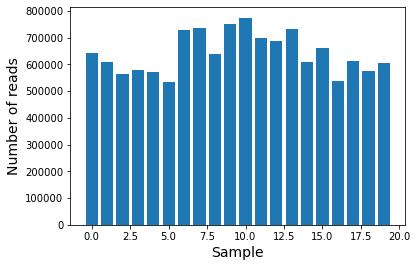

In [36]:
plt.bar([x for x in range(0,20)], sample_dataframe['merged_read_count'])

plt.xlabel('Sample', fontsize=14)
plt.ylabel('Number of reads', fontsize=14)

## Trim and aggregate with vsearch

In [37]:
def trim_aggregate(Sample_ID):
    # This function generates and runs two vsearch calls to trim and then aggregate the merged reads.
    # Trimming removes the variable degenreate sequences, which then  allows us to aggregate the sequences that have
    # the same FCY1 sequence with minimal influence from amplicn regions used for multiplexing.
       
    filepath = './merged_reads/'    
    filepath_merged = filepath+str(Sample_ID)+'.fasta'
    # get the merged read filepath based on the sample
    
    trim_path = filepath + str(Sample_ID)+ '_trim.fasta'
    aggregate_path = filepath +str(Sample_ID)+ '_agg.fasta'
    # generate output filepaths for the trimming and aggregating steps
    
    vsearch_trim_call = 'vsearch --fastx_filter '+filepath_merged+' --fastq_stripleft 76 --fastq_stripright 76 --fastaout ' + trim_path
    subprocess.check_output(vsearch_trim_call, shell=True)
    # generates and runs a vsearch call with the following parameters:
    #    --fastx_filter filepath_merged    vsearch program to be used and input: fastxfilter can perform different
    #                                      operations on fastq files
    #    --fastq_stripleft                 removes 76 bases from the 5p end
    #    --fastq_stripright 76             removes 76 bases from the 3p end
    #    --fastaout trim_path              ouput trimmed sequences the trim_path file                 
    
    vsearch_aggregate_call = 'vsearch --derep_fulllength '+ trim_path +' --relabel seq --output '+aggregate_path+' --sizeout'
    subprocess.check_output(vsearch_aggregate_call, shell=True)
    # generates and runs a vsearch call with the following parameters:
    #    --derep_fulllength trim_path    vsearch program to be used and input. derep_fulllength aggregates perfectly identical 
    #                                    sequences in the input fasta, dramatically reducing the number of sequences that then 
    #                                    need to be aligned
    #    --relabel seq                   changes header so that all sequence names begin by seq
    #    --output                        path where output will be written
    #    --sizeout                       append the size of the sequence cluster to the fasta header
    
    
trim_aggregate(0)
#test on sample 0

In [39]:
for sample_ID in list(sample_dataframe.index):
    
    trim_aggregate(sample_ID)


## Align sequences on FCY1 references

In [40]:
if 'amplicon_align' not in os.listdir():
    os.mkdir('./amplicon_align')

In [41]:
path_to_amplicons = './amplicon_sequences/FCY1_frags.fa'
amplicon_info_dict = get_dict_of_seq(path_to_amplicons)
# import amplicon sequences as a dcitionary of sequences

amplicon_dict = {}
# holder to rewrite amplicons in separate fasta files

for amplicon in amplicon_info_dict:
    # loops through the 3 fragments
    
    amplicon_name = amplicon.split('|')[0]
    amplicon_dict[amplicon_name] = amplicon_info_dict[amplicon]
    # get amplicon name
    
    amplicon_fasta_path = './amplicon_sequences/'+amplicon_name+'.fasta'
    # define a path for a fasta file containing only the amplicon sequence
        
    with open(amplicon_fasta_path, 'w') as dest:
        # open individual amplicon output file
        
        seq_ID = '>'+amplicon_name+'\n'
        seq = amplicon_dict[amplicon_name]+'\n'
        # generate strings to be written
        
        dest.write(seq_ID)
        dest.write(seq)
        # write header and sequences to file

In [42]:
def needle_align_on_ref(Sample_ID):
    # this function aligns the sequences from an aggregated read fasta file to the appropriate
    # reference FCY1 fragment based on the sample number. The alignment is performed using the 
    # Needle aligner from the Emboss suite. Input is:
    #    Sample_ID    the sample ID in the sample DataFrame
    
    frag = 'F'+str(sample_dataframe.loc[Sample_ID]['fragment'])
    # based on information present in the sample DataFrame, determine on which FCY1 fragment
    # to align the sequences
    
    if frag == 'F1':
        ref_orf = 'FCY1_frag_1'
    elif frag == 'F2':
        ref_orf = 'FCY1_frag_2'
    elif frag == 'F3':
        ref_orf = 'FCY1_frag_3'
    # sets the appropriate reference sequence
               
    ref_seq = amplicon_dict[ref_orf]
    ref_fasta_path = './amplicon_sequences/'+ref_orf+'.fasta '
    # get the path to the reference fasta     
    
    filepath = './merged_reads/'+str(Sample_ID)+'_agg.fasta'
    # path to the aggregate reads
    
    needle_out = './amplicon_align/'+str(Sample_ID)+'_agg.needle'
    #alignment ouput file path
    
    needle_call = 'needle -auto -gapopen 50 -asequence '+ ref_fasta_path
    needle_call += '-bsequence '+ filepath +' -aformat3 markx10 -outfile '+needle_out   
    subprocess.check_output(needle_call, shell = True)
    # generate and run a needle call with the following parameters:
    #    -auto                        do not run in interactive mode
    #    -gapopen 50                  increase penalty for gap in the alignment. This helps
    #                                 with instances where there are no indels in the read but
    #                                 needle still opens a gap 
    #    -asequence ref_fasta_path    reference sequence fasta file
    #    -bsequence filepath          query sequences in fasta format
    #    -aformat3 markx10            choose the ouput format
    #    -ourfile needle_out          define output file path
    
   
    return

needle_align_on_ref(0)
# test on sample 0

In [56]:
for sample_ID in list(sample_dataframe.index):
    # for all samples
    
    needle_align_on_ref(sample_ID)
    # align sequences

In [57]:
def parse_needle_output(path):
    # this function parses the needle alignments and extract the aligned sequencesreference and query seuqences. It takes as input the 
    # path to the needle output
    
    n_aligns = 0
    # counter for the number of alignments
    
    align_seqs_dict = {}
    # empty container that will hold the aligned sequences
                
    needle_align_path = './amplicon_align/'+path+'.needle'
    # path to the alignments
        
    with open(needle_align_path, 'r') as source:
        # open the alignment

        current_align = ''
        current_qseq = ''
        current_sseq = ''
        # empty container objects for data processing
        
        qseq_done = 0
        #counter for the number of alignments processed

        for line in source:
            # loop through the file

            if line.startswith('>>>') == True:
                # detect headers

                n_aligns +=1
                # increment alignment counter by one

                align_name = line.strip('>>>')
                # get alignment name, looks like this:    >>>FCY1_frag_1, 256 nt vs seq1;size=36221, 233 nt

                if n_aligns != 1:
                    # if this is not the first alignment

                    align_seqs_dict[current_align] = [current_qseq, current_sseq]
                    # add the information on the previous alignment to the dict

                    current_align = align_name
                    # update the name for the new entry

                    current_qseq = ''
                    current_sseq = ''
                    # reset temporary variables

                    qseq_done = 0
                    # reset indicator for query sequence extraction

                else:
                    current_align = align_name
                    # for the fisrt sequence, just need to store the align name

 
            elif line.startswith(';') == False and line.startswith('>') == False and line.startswith('\n') == False and line.startswith('#') == False:
                # skip all the useless lines to process only the aligned sequences

                if qseq_done == 1:
                    current_sseq += line.strip('\n')
                    # if the query seq is done (qseq = 1), add sequence to the subject

                else:
                    current_qseq += line.strip('\n')
                    # if the query seq is not done, continue to update it

            elif line.startswith('#--') == True:
                align_seqs_dict[align_name] = [current_qseq, current_sseq]
                # update dict with info from the last entry in the alignment sequence

            else:
                if qseq_done == 0 and current_qseq != '':
                    qseq_done =1
                    # if the qseq is recorded, update value
                
                    
    return align_seqs_dict, n_aligns
    # update
                    
                    
parse_needle_output('0_agg')
# test for sample 0
                    
                    
                
                  

({'FCY1_frag_1, 256 nt vs seq1;size=36221, 233 nt\n': ['CAGCTTAAAGAGTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAG',
   '-----------GTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTG------------'],
  'FCY1_frag_1, 256 nt vs seq2;size=4493, 232 nt\n': ['CAGCTTAAAGAGTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAG',
   '-----------GTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGG

## Detect mutations in aligned sequences

In [59]:
align_count_dict = {}

mut_count_dict = {}



def find_mutations(path, fragment):
    # For a given path and FCY1 cds fragment (the reference sequence), runs the Needle alignment parser and
    # then goes through the extracted alignments to find the differences between the aligned query and the reference.
    #
    
    allele_dict = {}
    # empty dict that will hold the sequence name :mutations information
    
    if fragment == 'F1':
        ref_orf = 'FCY1_frag_1'    
    elif fragment == 'F2':        
        ref_orf = 'FCY1_frag_2'        
    elif fragment == 'F3':        
        ref_orf = 'FCY1_frag_3'
    # depending on the sample, select the approptiate reference sequence
    
    align_dict, align_count = parse_needle_output(path)
    # get the parsed alignments for the sample
    
    for entry in list(align_dict.keys()):
        # loop through aligned sequences

        read_var_list = []
        # temporary holder for mutations found in sequence

        query_seq = align_dict[entry][1]
        # aligned cds sequence of the strain

        align_ref = align_dict[entry][0]
        # aligned cds sequence of the reference

        gap_adjust = 0
        # value used to adjust the cds sequence index for the presence of insertions in the strain sequence vs the 
        # reference cds

        backtrack_adjust = 0
        # value used to adjust the cds sequence index for the presence of deletions in the strain sequence vs the 
        # reference cds

        temp_var = None
        # temporary variable to hold the sequence of an insertion or deletion as a string. When the gap ends, annotation 
        # will be added to read_var_list

        indel_start = 0
        # position start of the indel annotation in the reference sequence, with adjustment for gap presence

        ref_seq_no_gaps = align_ref.replace('-','')
        # reference sequence with gaps removed

        align_start = (amplicon_dict[ref_orf].index(ref_seq_no_gaps))+1
        # position in the reference FCY1 fragment where the alignment starts

        query_seq_no_gaps = len(query_seq.replace('-',''))
        # length of the query when gaps are removed

        for nt in range(0, len(align_ref)):
            # iterates through the entire alignment of the strain prot sequence

            if query_seq[nt] == '-':
                # detect a deletion variant

                # logic for indel detection/annotation:
                #
                # suppose we have this alignment  
                #
                # 1 2 3 4 5 6 7 8 9
                # A T - - A A A T G    strain variant: del gaps are indexed because the aa index is based on reference
                # A T K P A - - T G
                # 1 2 3 4 5     6 7    reference: insert gaps not indexed because aa positions do exist in reference
                #
                # following this logic, every time an insertion is detected and annotated, the gap_adjust value is 
                # incremented by the length of the gap and used to adjust the variant mapping to make it match the 
                # reference index values. The indel aa postion is the first residue detected as part of the indel


                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'del'+ align_ref[nt]
                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    backtrack_adjust += 1

                else:

                    temp_var += align_ref[nt]
                    # if it is not, adds the following aa to the deletion annotation

                    backtrack_adjust += 1


            elif align_ref[nt] == '-':
                # detects an insertion variant

                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'ins'+ query_seq[nt]

                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence                   


                else:

                    temp_var += query_seq[nt]
                    # if it is not, adds the following aa to the insertion annotation

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence


            elif query_seq[nt] != align_ref[nt]:
                # detects a mismatch between the strain sequence and the reference


                variant = align_ref[nt]+'|'+str((nt+1-gap_adjust))+'|'+query_seq[nt]
                read_var_list.append(variant)
                # creates an annotation for the strain-reference aa mismatch and appends it to the list of 
                # annotations

            else:

                 if indel_start != 0:
                    # detects if there is currently an open gap entry. If there is, then the detected mismatch means 
                    # that it has now concluded

                    read_var_list.append(str((indel_start))+temp_var)
                    temp_var = None
                    indel_start = 0
                    # adds the indel annotation to the strain variant list and resets temporary variables for the next 
                    # indel entry


        if query_seq_no_gaps >=  len(ref_seq_no_gaps)*0.8 and len(read_var_list)<25:            
            allele_dict[entry] = read_var_list, align_start
            # apply a filter for alignment quality: the alignment must cover at least 80% of the reference sequence and
            # there must be less than 25 differences between the query and the reference (insertions, deletions or SNVs)
                           
    return allele_dict

# looks good for all alleles tested      


In [60]:
pool_1_muts = find_mutations('0_agg', 'F1')
# test on sample 0

In [61]:
def get_n_align(allele_dict):
    # for a given dict (sequence: mutations), add up the number of
    # aggregated sequences for each entry to get the total number of 
    # reads that passed the alignment filter
    
    n_align = 0
    # counter
    
    for seq in list(allele_dict.keys()):
        # loop through entries in the dict
        
        var_info = seq.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # get the number of reads for a specific sequence
        
        n_align += var_count
        # add it to the count
    
    return n_align
    # return the total

get_n_align(pool_1_muts)
# test on sample 0

639835

In [62]:
639961

639961

## Map mutations to the coding sequence

The next three functions go through the set of sequence variants extracted from the alignments by the parse_needle_output and find_mutations functions and map the detected variants on the coding sequence. This is where most of the quality filters are applied on the alignments to detect and count variants. 

the algorithm is:
 - Do not consider indels at the start of of the alignment (primer regions)
 - Only consider sequences with no more than 3 mutations 
 - Trash sequences with indels
 - The mutations must occur within the same codon, or be a combination of codon specific mutations and in the primer regions


In [63]:
def get_variant_count_1(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    # container that will store the abundance of protein variants
    
    variants = list(mutation_set.keys())
    # list of detected variants from the find_mutations output
    
    codon_groups = {}
    # This dict will hold the positions in the reference cds that correspond to the same codon.
    # This allows for easy verification that detected mutations occur within the same codon later 
    # downstream in the function
    
    codon = 1
    # counter for codon position in the FCY1 fragment
    
    wt_count =0
    valid_seq=0
    # counters for the number of WT cds detected and the number sequences passing the quality filter
    
    for nt in range(0, n_aa*3):
        # loops through the cds positions in the FCY1 fragment
        
        pos = nt+34
        # adds the primer region offset specific to the fragment
        
        if nt % 3 == 0:
            codon += 1
            # use modulo to delimit and increment codons
            
        codon_groups[pos] = codon
        # add cds position to dict of codon groups
        
        variant_abundance_dict[codon] = {}
        # make an empty container of codon abundances for this specific codon
        
    wt_codons = {}
    # container for the WT codons of the FCY1 fragment
        
    ref = amplicon_dict[ref_seq]
    # reference dna sequence
    
    for aa in range(0, n_aa):
        # for each amino acid in the fragment
        
        offset = 33
        start = offset+(aa*3)
        # define the starting position of the codon in the DNA sequence based on 
        # aa position and offset
        
        wt_codon=ref[start:(start+3)]        
        wt_codons[(aa+codon_start)] = wt_codon
        # extract WT codons from sequence and add it to the dict
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan 
        # set abundance to nan for wt codons at each positions (the WT sequence
        # is the same across all positions, so impossible to distinguish)          
    
    for variant in variants:
        # loop through detected sequence variants
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # extract the number of counts
               
        mut_list = mutation_set[variant][0]
        # get the list of differences between the sequence and the reference
        
        filtered_list = []
        # list of mutations after filtering
        
        if var_count>=20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequences
        
            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions
                    
                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence
                        
                        if mut_pos >=34 and mut_pos <= 231:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon
                            
                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list
                        
                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts
                        
                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured
                        
                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured
                                                                      
                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions
                            
                            codon_pos = (mut_pos-1)%3
                            # convert cds position to position within 
                            
                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object
                            
                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                                                   
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
                            
  
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        wt_count+=var_count
                        # if no mutations occured in the cds (all in the primer region)
                        # increment the WT seq counts
                    
                    
        elif var_count < 20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequence

            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs

                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype

                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions

                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence

                        if mut_pos >=34 and mut_pos <= 231:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon

                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list

                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts

                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured

                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured

                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions

                            codon_pos = (mut_pos-1)%3
                            # convert cds position to position within

                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object

                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry

                    
    return variant_abundance_dict, wt_count

frag1_dict = get_variant_count_1(pool_1_muts, 'FCY1_frag_1', 34, 2,66)
# test with sample 0    

In [64]:
frag1_dict[1]

44514

In [65]:
def get_variant_count_2(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    # container that will store the abundance of protein variants
    
    variants = list(mutation_set.keys())
    # list of detected variants from the find_mutations output
    
    codon_groups = {}
    # This dict will hold the positions in the reference cds that correspond to the same codon.
    # This allows for easy verification that detected mutations occur within the same codon later 
    # downstream in the function
    
    codon = 48
    # counter for codon position in the FCY1 fragment
    
    wt_count =0
    valid_seq=0
    # counters for the number of WT cds detected and the number sequences passing the quality filter
    
    for nt in range(0, n_aa*3):
        # loops through the cds positions in the FCY1 fragment
        
        pos = nt+23
        # adds the primer region offset specific to the fragment
        
        if nt % 3 == 0:
            codon += 1
            # use modulo to delimit and increment codons
            
        codon_groups[pos] = codon
        # add cds position to dict of codon groups
        
        variant_abundance_dict[codon] = {}
        # make an empty container of codon abundances for this specific codon
        
    wt_codons = {}
    # container for the WT codons of the FCY1 fragment
        
    ref = amplicon_dict[ref_seq]
    # reference dna sequence
    
    for aa in range(0, n_aa):
        # for each amino acid in the fragment
        
        offset = 22
        start = offset+(aa*3)
        # define the starting position of the codon in the DNA sequence based on 
        # aa position and offset
        
        wt_codon=ref[start:(start+3)]
        wt_codons[(aa+codon_start)] = wt_codon
        # extract WT codons from sequence and add it to the dict
        
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan
        # set abundance to nan for wt codons at each positions (the WT sequence
        # is the same across all positions, so impossible to distinguish)              
    
    for variant in variants:
        # loop through detected sequence variants
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # extract the number of counts
               
        mut_list = mutation_set[variant][0]
        # get the list of differences between the sequence and the reference
        
        filtered_list = []
        # list of mutations after filtering
        
        if var_count>=20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequences
        
            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions
                    
                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence
                        
                        if mut_pos >=23 and mut_pos <= 208:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon
                            
                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list
                    
                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts
                        
                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured
                        
                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured
                                                                      
                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions
                            
                            codon_pos = (mut_pos-2)%3
                            # convert cds position to position within codon
                            
                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object
                            
                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                                                    
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        wt_count+=var_count
                        # if no mutations occured in the cds (all in the primer region)
                        # increment the WT seq counts

                    
        elif var_count < 20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequence

            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions

                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence

                        if mut_pos >=23 and mut_pos <= 208:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon

                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list

                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts

                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured

                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured

                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions

                            codon_pos = (mut_pos-2)%3
                            # convert cds position to position within

                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object

                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string

                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it                            
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
                    
    return variant_abundance_dict, wt_count

In [66]:
def get_variant_count_3(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    # container that will store the abundance of protein variants
    
    variants = list(mutation_set.keys())
    # list of detected variants from the find_mutations output
    
    codon_groups = {}
    # This dict will hold the positions in the reference cds that correspond to the same codon.
    # This allows for easy verification that detected mutations occur within the same codon later 
    # downstream in the function
    
    codon = 92
    # counter for codon position in the FCY1 fragment
    
    wt_count =0
    valid_seq=0
    # counters for the number of WT cds detected and the number sequences passing the quality filter
    
    for nt in range(0, n_aa*3):
        # loops through the cds positions in the FCY1 fragment
        
        pos = nt+23
        # adds the primer region offset specific to the fragment
        
        if nt % 3 == 0:
            codon += 1
            # use modulo to delimit and increment codons
            
        codon_groups[pos] = codon
        # add cds position to dict of codon groups
        
        variant_abundance_dict[codon] = {}       
        # make an empty container of codon abundances for this specific codon
        
    wt_codons = {}
    # container for the WT codons of the FCY1 fragment
        
    ref = amplicon_dict[ref_seq]
    # reference dna sequence
    
    for aa in range(0, n_aa):
        # for each amino acid in the fragment
        
        offset = 22
        start = offset+(aa*3)
        # define the starting position of the codon in the DNA sequence based on 
        # aa position and offset
        
        wt_codon=ref[start:(start+3)]
        wt_codons[(aa+codon_start)] = wt_codon
        # extract WT codons from sequence and add it to the dict
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan
        # set abundance to nan for wt codons at each positions (the WT sequence
        # is the same across all positions, so impossible to distinguish)       
    
    for variant in variants:
        # loop through detected sequence variants
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # extract the number of counts
               
        mut_list = mutation_set[variant][0]
        # get the list of differences between the sequence and the reference
        
        filtered_list = []
        # list of mutations after filtering
        
        if var_count>=20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequences
                
            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions
                    
                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence
                        
                        if mut_pos >=23 and mut_pos <= 220:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon
                            
                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list
                        
                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts
                        
                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured
                        
                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured
                                                                      
                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions
                            
                            codon_pos = (mut_pos-2)%3
                            # convert cds position to position within 
                            
                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object
                            
                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                            
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
      
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        wt_count+=var_count
                        # if no mutations occured in the cds (all in the primer region)
                        # increment the WT seq counts                    
                    
        elif var_count < 20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequence

            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions

                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence

                        if mut_pos >=23 and mut_pos <= 220:
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon

                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list

                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts

                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured

                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured

                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions

                            codon_pos = (mut_pos-2)%3
                            # convert cds position to position within

                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object

                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it

                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
                            
    return variant_abundance_dict, wt_count    

In [67]:
if 'read_abundances' not in os.listdir():
    os.mkdir('./read_abundances')

## Quantify variant raw and relative abundances

In [76]:
def get_timepoint_fraction_df(Sample_ID):
    # this function runs parse_needle_output, find_mutations and the appropriate get_variant_count 
    # function for each sample, and then compiles the result as a DataFrame of relative abundance
    # which will be then be used to compute log2 fold-change. The function also returns the raw read
    # read counts as a separate DataFrame
    
    frag = 'F' + str(sample_dataframe.loc[Sample_ID]['fragment'])
    # check the sample corresponds to which FCY1 fragment
    
    align_path  = str(Sample_ID)+'_agg'
    # path to sequence alignment output
    
    allele_dict=find_mutations(align_path, frag)
    # get variant for each aligned aggregated sequence
    
    if frag =='F1':
        mut_dict, wt_count = get_variant_count_1(allele_dict, 'FCY1_frag_1', 34, 2,66)
    if frag =='F2':
        mut_dict, wt_count = get_variant_count_2(allele_dict, 'FCY1_frag_2', 22, 49,62)
    if frag =='F3':
        mut_dict, wt_count = get_variant_count_3(allele_dict, 'FCY1_frag_3', 22, 93,66)
    # Run the appropriate get_variant_count call based on the FCY1 fragment
    
    variant_df = pd.DataFrame(mut_dict)
    # convert variant abundances (codon level dict) to a dataframe
    
    array_size=len(variant_df.to_numpy().flatten())
    # check total array size (should be number of codon*64)    
    
    
    read_total = variant_df.sum().sum()+wt_count+array_size
    # Use the sum of variant read counts, the number of wt counts, and the array size
    # to get the total number of reads for the library. To make log2 fold-change calculations 
    # possible in cases were variant abundance drops to 0, we  follow the standard practice of 
    # adding +1 to read counts for every possible variant. As such, we add the array size to 
    # the total number of reads
    
    print(Sample_ID, read_total, array_size)
    # print values for QC
    
    variant_df_no_NaN = variant_df.fillna(0)
    # replace nans with 0
    
    variant_df_no_NaN = variant_df_no_NaN + 1
    # add one to all counts
    
    read_fraction_df = variant_df_no_NaN/(read_total)
    print(read_total, 1/read_total)
    # calulate relative abundance for all variants, and print for QC
    
    read_fraction_df.rename_axis(read_total, inplace=True)
    # rename the axis so the read total is present in the output csv
    
    df_out_path='./read_abundances/'+str(Sample_ID)+'_read_frac.csv'    
    read_fraction_df.to_csv(df_out_path, sep=',')
    # write the variant relative abundance DataFrame to file as a csv
    
    return read_fraction_df, variant_df, wt_count

In [119]:
frac_df_dict = {}
# container for variant frequency information.

raw_count_df_dict = {}
# container for raw count information.

wt_count_df_dict = {}
# container for wt sequence count information.

for sample_ID in list(sample_dataframe.index):    
    frac_df, raw_count_df, wt_count = get_timepoint_fraction_df(sample_ID)
    # determine the relative read abundance of variants
    # in all samples
    
    frac_df_dict = frac_df
    # add frequency info to the dict
    
    raw_count_df_dict[sample_ID] = raw_count_df
    # add raw counts to the dict
    
    wt_count_df_dict[sample_ID] = wt_count
    # add wt counts to the dict

0 526505.0 4224
526505.0 1.8993171954682292e-06
1 501171.0 4224
501171.0 1.995326944296458e-06
2 522882.0 4224
522882.0 1.912477384954923e-06
3 513527.0 4224
513527.0 1.947317278351479e-06
4 453368.0 4224
453368.0 2.2057136807185334e-06
5 424193.0 4224
424193.0 2.357417496281174e-06
6 598383.0 3968
598383.0 1.6711704710862442e-06
7 604809.0 3968
604809.0 1.653414549055983e-06
8 545516.0 3968
545516.0 1.8331268010470821e-06
9 639063.0 3968
639063.0 1.5647909517528007e-06
10 614647.0 3968
614647.0 1.626950103067289e-06
11 552830.0 3968
552830.0 1.808874337499774e-06
12 602569.0 3968
602569.0 1.65956097973842e-06
13 646137.0 3968
646137.0 1.5476593973104774e-06
14 505093.0 4224
505093.0 1.979833416816309e-06
15 547001.0 4224
547001.0 1.8281502227601047e-06
16 491521.0 4224
491521.0 2.034501069130312e-06
17 557991.0 4224
557991.0 1.7921436008824516e-06
18 460068.0 4224
460068.0 2.173591729918186e-06
19 482087.0 4224
482087.0 2.0743143872371586e-06


In [120]:
sample_dataframe

,timepoint,fragment,replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,merged_read_count
Sample_ID,,,,,,,,,
0,T0,1,1,1,1,1,3,./demultiplexed_reads/0_indexes_1_3_1_1,640462
1,T0,1,2,1,1,2,3,./demultiplexed_reads/1_indexes_1_3_1_2,607570
2,Cy,1,1,1,1,3,3,./demultiplexed_reads/2_indexes_1_3_1_3,562413
3,Cy,1,2,1,1,4,3,./demultiplexed_reads/3_indexes_1_3_1_4,577128
4,5FC,1,1,1,1,5,3,./demultiplexed_reads/4_indexes_1_3_1_5,572270
5,5FC,1,2,1,1,6,3,./demultiplexed_reads/5_indexes_1_3_1_6,533479
6,T0,2,1,2,2,1,3,./demultiplexed_reads/6_indexes_2_3_2_1,729076
7,T0,2,2,2,2,2,3,./demultiplexed_reads/7_indexes_2_3_2_2,737099
8,Cy,2,1,2,2,3,3,./demultiplexed_reads/8_indexes_2_3_2_3,640245


In [121]:
used_reads_dict = {}
bar_name_dict = {}

for sample in list(sample_dataframe.index):
    # go through samples
    
    fragment = sample_dataframe.loc[sample]['fragment']
    condition = sample_dataframe.loc[sample]['timepoint']
    replicate = sample_dataframe.loc[sample]['replicate']
    # get fragment, timepoint, replicate
    
    bar_name = str(fragment) + '_' + str(condition) + '_' + str(replicate)
    # combine information to make a name for xticks labels in the next plots    
    
    array_size = len(raw_count_df_dict[sample].to_numpy().flatten())
    # check total array size (should be number of codon*64) 
    
    wt_count = wt_count_df_dict[sample]
    # retrieve wt count from dict
    
    used_reads = raw_count_df_dict[sample].sum().sum()+wt_count-array_size
    # calculate total number of usable reads based on total variant count, wt count,
    # dans adjustment for 0 count variants
    
    used_reads_dict[sample] = used_reads    
    bar_name_dict[sample] = bar_name
    # add total number of reads and tick names to a dict

Text(0, 0.5, 'Library')

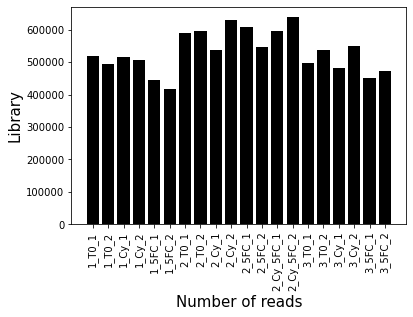

In [238]:
plt.bar(range(0,20), height=[used_reads_dict[x] for x in range(0,20)], color='k')
# draw bars

plt.xticks(range(0,20), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# write ticks and rotate

plt.xlabel('Number of reads', fontsize=15)
plt.ylabel('Library', fontsize=15)
# label axis

In [239]:
under_10_reads_codon = {}

for sample in list(sample_dataframe.index):

    flattened_array = raw_count_df_dict[sample].to_numpy().flatten()
    flattened_array = flattened_array[~np.isnan(flattened_array)]
    # get the distribution of codon abundances, but without nan values
    
    under_10_reads_codon[sample]=np.count_nonzero(flattened_array < 10)/(63*len(raw_count_df_dict[sample].columns))*100
    # compute the fraction of variants with less than 10 reads in each library
    
under_10_reads_codon
# show the values

{0: 1.0822510822510822,
 1: 1.2265512265512266,
 2: 39.7065897065897,
 3: 41.17364117364117,
 4: 39.201539201539205,
 5: 39.36988936988937,
 6: 0.7424475166410651,
 7: 0.7168458781362007,
 8: 62.6216077828981,
 9: 59.13978494623656,
 10: 18.074756784434204,
 11: 20.43010752688172,
 12: 47.64464925755249,
 13: 46.51817716333845,
 14: 1.2506012506012507,
 15: 1.2987012987012987,
 16: 41.77489177489178,
 17: 39.27368927368927,
 18: 30.63973063973064,
 19: 30.59163059163059}

Text(0, 0.5, '% codon variants < 10 reads')

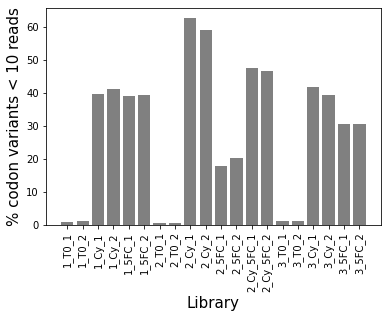

In [240]:
plt.bar(range(0,20), height=[under_10_reads_codon[x] for x in range(0,20)], color='grey')
# draw bars

plt.xticks(range(0,20), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# write ticks

plt.xlabel('Library', fontsize=15)
plt.ylabel('% codon variants < 10 reads', fontsize=15)
# label axis

1_T0_1 32.0 231.0
1_T0_2 30.0 220.0
1_Cy_1 2.0 105.0
1_Cy_2 2.0 101.0
1_5FC_1 2.0 401.0
1_5FC_2 1.0 382.0
2_T0_1 39.0 285.0
2_T0_2 37.0 289.0
2_Cy_1 1.0 100.0
2_Cy_2 1.0 125.0
2_5FC_1 3.0 483.4499999999998
2_5FC_2 3.0 436.5
2_Cy_5FC_1 2.0 700.0499999999997
2_Cy_5FC_2 2.0 789.4499999999989
3_T0_1 29.0 210.0
3_T0_2 30.0 230.64999999999964
3_Cy_1 1.0 181.0
3_Cy_2 1.0 206.0
3_5FC_1 2.0 419.2999999999997
3_5FC_2 2.0 435.0


Text(10.5, 400000, 'ACT_89_GTT')

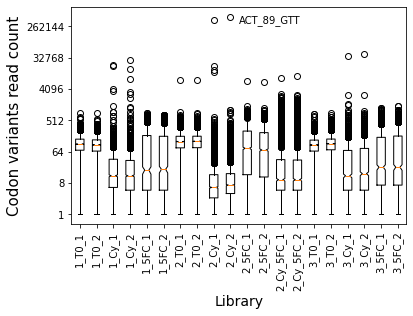

In [244]:

array_list = []

for sample in list(sample_dataframe.index):
    # go though samples
    
    flattened_array = raw_count_df_dict[sample].to_numpy().flatten()
    flattened_array = flattened_array[~np.isnan(flattened_array)]
    # get the distribution of codon abundances
    
    array_list.append(flattened_array)
    
    print(bar_name_dict[sample], np.nanpercentile(raw_count_df_dict[sample].to_numpy().flatten(), 5), np.nanpercentile(raw_count_df_dict[sample].to_numpy().flatten(), 95))
    # get 5th percentile of codon level variant abundance for the different libraries
    
plt.boxplot(array_list, notch=True, )
# draw boxplot

plt.yscale('log', base=2)
# set scale to log2

plt.yticks([1 , 8 , 64, 512, 4096, 32768, 262144], [1 , 8 , 64, 512, 4096, 32768, 262144])
plt.xticks(range(1,21), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# draw ticks

plt.xlabel('Library', fontsize=14)
plt.ylabel('Codon variants read count', fontsize=15)
plt.text(10.5,400000, 'ACT_89_GTT', va='center')
# write labels

In [243]:
2**13

8192

In [186]:
codontable_standard = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
    }
# standard codon table as a dictionnary

def convert_dict_to_aa(codon_dict):
    # takes a codon level raw count of frequency dict 
    # of dict and sum values for synonymous codons to 
    # convert it to the amino acid level
    
    aa_dict_of_dicts = {}
    # container for the new dict of dict
    
    for pos in list(codon_dict.keys()):
        # loops through positions in the dict
        
        aa_dict_of_dicts[pos] = {}
        # position level dict
        
        for codon in list(codon_dict[pos].keys()):
            # loops through codon at a specific position
            
            aa = codontable_standard[codon]
            # get aa encoded by codon           
            
            if np.isnan(codon_dict[pos][codon]) == True and aa in ['M', 'W']:
                aa_dict_of_dicts[pos][aa] = np.nan
                # Detect positions for which only one codon is possible.
                # If not detected (either is the WT aa or not in library),
                # set the count to nan
                
            elif np.isnan(codon_dict[pos][codon]) == False:
                # if the codon was detected
            
                if aa in list(aa_dict_of_dicts[pos].keys()):           
                    aa_dict_of_dicts[pos][aa] += codon_dict[pos][codon]
                    # if an entry already exists for aa, increment it

                else:
                    aa_dict_of_dicts[pos][aa] = codon_dict[pos][codon]
                    # if not, create one
                
    return aa_dict_of_dicts


In [187]:
#convert_dict_to_aa(raw_count_df_dict[0].to_dict())



In [219]:
aa_raw_count_list = []
# container for the distributions of aa level read counts

for sample in list(sample_dataframe.index):
    # loop through the samples
    
    aa_raw_count = pd.DataFrame.from_dict(convert_dict_to_aa(raw_count_df_dict[sample].to_dict()))
    # use convert dict to aa on the codon level raw counts df
    
    flattened_array = aa_raw_count.to_numpy().flatten()
    flattened_array = flattened_array[~np.isnan(flattened_array)]
    # get the distribution of codon abundances
    
    aa_raw_count_list.append(flattened_array)
    # get the distribution of codon abundances
        
    print(bar_name_dict[sample], np.nanpercentile(aa_raw_count.dropna().to_numpy().flatten(), 5))
    # get 5th percentile of aa level variant abundance for the different libraries


1_T0_1 96.0 842.3499999999999
1_T0_2 87.65 802.0499999999997
1_Cy_1 6.050000000000004 350.9000000000001
1_Cy_2 6.0 328.59999999999945
1_5FC_1 6.0 1437.5999999999995
1_5FC_2 6.0 1386.1999999999998
2_T0_1 110.9 1031.5499999999995
2_T0_2 109.95 1048.0
2_Cy_1 6.0 404.75
2_Cy_2 5.0 443.0499999999997
2_5FC_1 13.0 1718.75
2_5FC_2 12.0 1518.6499999999985
2_Cy_5FC_1 6.0 2603.399999999999
2_Cy_5FC_2 6.0 2716.5
3_T0_1 84.0 786.0
3_T0_2 86.65 850.3999999999996
3_Cy_1 5.0 760.6499999999999
3_Cy_2 6.0 796.95
3_5FC_1 9.0 1556.8499999999997
3_5FC_2 8.0 1575.5


Text(10.5, 400000, 'S89V')

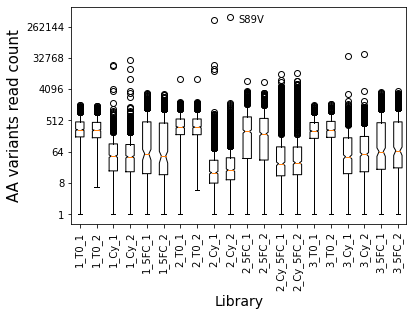

In [223]:
plt.boxplot(aa_raw_count_list, notch=True)
# draw boxplot

# set scale to log2
plt.yscale('log', base=2)
plt.yticks([1 , 8 , 64, 512, 4096, 32768, 262144], [1 , 8 , 64, 512, 4096, 32768, 262144])
plt.xticks(range(1,21), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# draw ticks

plt.xlabel('Library', fontsize=14)
plt.ylabel('AA variants read count', fontsize=15)
# write labels

plt.text(10.5,400000, 'S89V', va='center')
# annotate the graph to ID the outlier variant

In [276]:
if 'figures' not in os.listdir():
    os.mkdir('./figures')

## Make figure SX

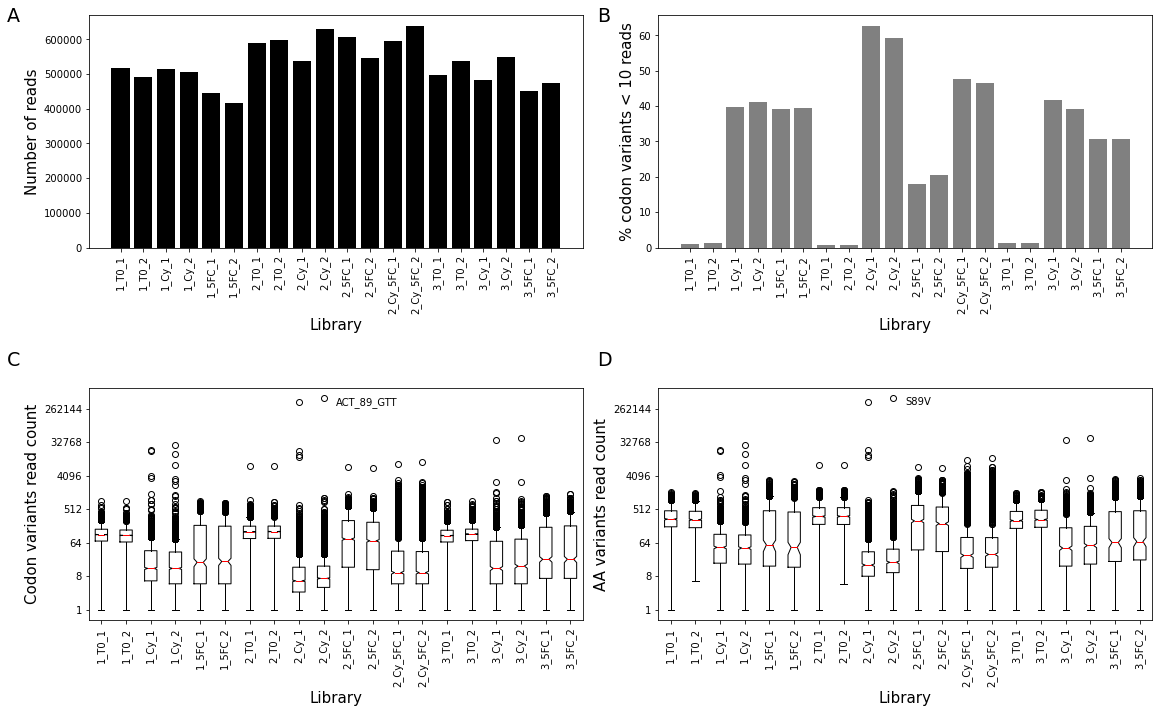

In [280]:
plt.figure(figsize=(16,10))
# set size


########################################################
plt.subplot(221)
plt.bar(range(0,20), height=[used_reads_dict[x] for x in range(0,20)], color='k')
plt.xticks(range(0,20), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
plt.xlabel('Library', fontsize=15)
plt.ylabel('Number of reads', fontsize=15)

plt.text(-5,650000, 'A', fontsize=19)
plt.text(21,650000, 'B', fontsize=19)

plt.text(-5,-340000, 'C', fontsize=19)
plt.text(21,-340000, 'D', fontsize=19)


########################################################
plt.subplot(222)
plt.bar(range(0,20), height=[under_10_reads_codon[x] for x in range(0,20)], color='grey')
plt.xticks(range(0,20), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
plt.xlabel('Library', fontsize=15)
plt.ylabel('% codon variants < 10 reads', fontsize=15)


#########################################################
plt.subplot(223)

plt.boxplot(array_list, notch=True, medianprops = dict(color='r'))
# draw boxplot

plt.yscale('log', base=2)
# set scale to log2

plt.yticks([1 , 8 , 64, 512, 4096, 32768, 262144], [1 , 8 , 64, 512, 4096, 32768, 262144])
plt.xticks(range(1,21), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# draw ticks

plt.xlabel('Library', fontsize=15)
plt.ylabel('Codon variants read count', fontsize=15)
# write labels
plt.text(10.5,400000, 'ACT_89_GTT', va='center')


########################################################
plt.subplot(224)

plt.boxplot(aa_raw_count_list, notch=True, medianprops = dict(color='r'))
# draw boxplot

# set scale to log2
plt.yscale('log', base=2)
plt.yticks([1 , 8 , 64, 512, 4096, 32768, 262144], [1 , 8 , 64, 512, 4096, 32768, 262144])
plt.xticks(range(1,21), labels=[bar_name_dict[x] for x in range(0,20)], rotation=90)
# draw ticks

plt.xlabel('Library', fontsize=15)
plt.ylabel('AA variants read count', fontsize=15)
# write labels

plt.text(10.5,400000, 'S89V', va='center')
# annotate the graph to ID the outlier variant

plt.tight_layout()
# prevent overlap between labels

plt.savefig('./figures/read_count_abundance.svg', format='svg', dpi=300)
# save figure to file

## Generate table with raw counts

In [333]:
FCY1_codon_opt_cds = "ATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTT"\
                     "GATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGAT"\
                     "TGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAA"\
                     "AATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGA"\
                     "ACGTCCACAAGACTGGTTCGAAGATATTGGTGAA"
# WT codon optimized FCY1 coding sequence
                
FCY1_codon_opt_cds

'ATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAA'

In [334]:
index_codon_col = {}
# empty container that will hold the    index: FCY1 aa position    entries (2-159)
index_position_col = {}
# empty container that will hold the    index: codon    entries (from the standard codon table)
is_wt_col = {}
# empty container that will hold the    index: wt    entries (1=WT codon, 0=not the WT)

index_val=0
# counter for index value, from pos 2 to 158 = 157 positions * 64 codons = 10048 entries

for position in range(2,159):
    # go through the positions in FCY1
    
    wt_codon = FCY1_codon_opt_cds[(position-1)*3:(position*3)]
    # get the wt codon sequence for that position

    for codon in range(0, 64):
        # loop through the codons in the standard translation table

        index_codon_col[index_val] = list(codontable_standard.keys())[codon]
        # associate 0 based index with codon, adjusted for position in FCY1

        index_position_col[index_val] = position
        # associate 0 based index with position in FCY1
        
        if list(codontable_standard.keys())[codon] == wt_codon:
            is_wt_col[index_val] = 1
        else:
            is_wt_col[index_val] = 0
            # check if codon is the WT, and set is_wt_col accordingly

        index_val+=1
        # increment 0 based index
            
initialized_df = pd.concat([pd.Series(index_position_col, name='position'), pd.Series(index_codon_col, name='codon'), pd.Series(is_wt_col, name='WT')],axis=1)
# concatenate columns to generate empty DaraFrame

initialized_df

,position,codon,WT
0,2,ATA,0
1,2,ATC,0
2,2,ATT,0
3,2,ATG,0
4,2,ACA,0
...,...,...,...
10043,158,TAG,0
10044,158,TGC,0
10045,158,TGT,0
10046,158,TGA,0


In [335]:

for sample in list(sample_dataframe.index):
    # loop through samples
    
    raw_counts = raw_count_df_dict[sample]
    # retrieve codon level raw read counts
    
    col_name = bar_name_dict[sample]
    # retrieve sample name
    
    positions = list(raw_counts.columns)
    # get list of FCY1 positions in the DatFrame
    
    index_val = 0
    # counter for 0 based index
    
    col_dict = {}
    # empty container for what will become the sample
    # specific DataFrame column

    for position in range(2,159):
        # loop through aa positions in FCY1

        for codon in range(0, 64):
            # loop through possible codons at that position
            
            codon_seq = list(codontable_standard.keys())[codon]
            # convert position in codontable_standard keys in to DNA:
            # sequence
            
            if position in positions:
                # check if current position in the loop is in the sample
                
                col_dict[index_val] = raw_counts.loc[codon_seq][position]
                # if so, add the raw count for the corresponding codon

            index_val+=1
            # increment 0 based index
            
    initialized_df[col_name] = pd.Series(col_dict)
    # add new column to DataFrame, same names as the bar plots
        
initialized_df.to_csv('./codon_counts.csv', sep=',', na_rep='nan')
# Save DataFrame to CSV, and represent nan values as nan

In [336]:
initialized_df

,position,codon,WT,1_T0_1,1_T0_2,1_Cy_1,1_Cy_2,1_5FC_1,1_5FC_2,2_T0_1,...,2_5FC_1,2_5FC_2,2_Cy_5FC_1,2_Cy_5FC_2,3_T0_1,3_T0_2,3_Cy_1,3_Cy_2,3_5FC_1,3_5FC_2
0,2,ATA,0,62.0,40.0,36.0,53.0,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ATC,0,102.0,89.0,47.0,56.0,5.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ATT,0,53.0,77.0,70.0,88.0,2.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,ATG,0,81.0,82.0,64.0,63.0,4.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,ACA,0,69.0,55.0,45.0,37.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,158,TAG,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,77.0,78.0,1.0,4.0,27.0,22.0
10044,158,TGC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,51.0,74.0,78.0,66.0,2.0,4.0
10045,158,TGT,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,134.0,126.0,116.0,166.0,7.0,3.0
10046,158,TGA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75.0,73.0,4.0,12.0,32.0,33.0
